# Gray-Scott Model for Coarse-Grained Reaction-Diffusion

In [163]:
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy import signal
import imageio

%matplotlib inline

images = []
f_images = []

def simulate(
    numIter, 
    A, B, F, 
    rf, growth_a, death_a, growth_b, growth_f,
    dt, dA, dB, dF, lapl, 
    plot_iter, filename):
    '''
    Simulate function
    Description: Simulate the Gray-Scott model for numIter iterations.
    Inputs:
        - numIter:  number of iterations
        - A:                prey matrix
        - B:                predator matrix
        - F:                fusion matrix
        - rf:               rate of fusion
        - growth_a:         growth rate of A
        - death_a:          death rate of A when competing cells are present
        - growth_b:         growth rate of B
        - growth_f:         growth of F
        - dt:               time constant
        - dA:               prey diffusion constant
        - dB:               predator diffusion constant
        - dF:               fusion diffusion constant
        - lapl:             3 x 3 Laplacian matrix to calculate diffusion

    Outputs:
        - A:   A matrices over the course of the simulation
        - B:   B matrices over the course of the simulation
        - F:   F matrices over the course of the simulation
    '''

    print("Running Simulation")
    start = time.time()

    A_history = []
    B_history = []
    F_history = []

    # Run the simulation
    for iter in range(numIter):
        A_new = A + (dA * signal.convolve2d(A, lapl, mode='same', boundary='fill', fillvalue=0) + (growth_a * A) - (death_a * (B + F)) - (rf * A * B)) * dt
        B_new = B + (dB * signal.convolve2d(B, lapl, mode='same', boundary='fill', fillvalue=0) + (growth_b * B) - (rf * A * B)) * dt
        F_new = F + (dF * signal.convolve2d(F, lapl, mode='same', boundary='fill', fillvalue=0) + (growth_f * F) + (rf * A * B)) * dt
        
        A = np.copy(A_new)
        B = np.copy(B_new)
        F = np.copy(F_new)

        A = A.clip(min=0, max=1)
        B = B.clip(min=0, max=1)
        F = F.clip(min=0, max=1)

        A_history.append(np.copy(A))
        B_history.append(np.copy(B))
        F_history.append(np.copy(F))

        if (iter % plot_iter == 0):
            # Create an image with each pixel color defined by:
            # R = resistant, G = fusion, B = sensitive
            # Assume that the matrix is square.
            size = len(A)
            img = np.zeros([size, size, 3], dtype=np.uint8)
            for i in range(size):
                for j in range(size):
                    A_val = A[i, j]
                    B_val = B[i, j]
                    F_val = F[i, j]
                    img[i, j, 0] = B_val * 255
                    img[i, j, 1] = F_val * 255
                    img[i, j, 2] = A_val * 255

            plt.clf()
            plt.imshow(img)
            name = filename+str(iter)+'.png'
            plt.savefig(name, dpi=100)
            images.append(imageio.imread(name))

    print('Simulation time: ', time.time() - start)
    
    return A_history, B_history, F_history

In [164]:
# _*_*_*_*_*_*_*_*_* GRID PROPERTIES *_*_*_*_*_*_*_*_*_*
grid_size = 101  # Needs to be odd
numIter = 5000
seed_size = 21  # Needs to be an odd number
A = np.ones((grid_size, grid_size))
B = np.zeros((grid_size, grid_size))
F = np.zeros((grid_size, grid_size))

# Seed the predators
mid = int(grid_size / 2)
# seed_radius = int(seed_size / 2)
# B[mid - seed_radius:mid + seed_radius + 1,
#   mid - seed_radius:mid + seed_radius + 1] = np.ones((seed_size, seed_size))
B[0:int(grid_size / 2), 0:grid_size] = np.ones((int(grid_size / 2), grid_size))


Running Simulation
Simulation time:  29.46405792236328
Final mean proportion of A:  0.09969279683295737
Final mean proportion of B:  0.7224685403161903
Final mean proportion of F:  0.6793406107370664


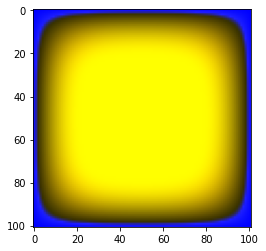

In [165]:
# _*_*_*_*_*_*_*_*_* SIMULATION VARIABLES *_*_*_*_*_*_*_*_*_*

rf = 0.0025 # Rate of fusion

growth_a = 0.0005
death_a = 0.0005
growth_b = 0.001
growth_f = 0.00075

dt = 1.0
dA = 0
dB = 0.5
dF = 0.5

lapl = np.array([[0.05, 0.2, 0.05], [0.2, -1.0, 0.2], [0.05, 0.2, 0.05]])
plot_iter = 50

filename = 'gs_images/f55_k117'

A_hist, B_hist, F_hist = simulate(numIter, A, B, F, rf, 
         growth_a, death_a, growth_b, growth_f, 
         dt, dA, dB, dF, lapl, plot_iter, filename)

print('Final mean proportion of A: ', A_hist[-1].mean())
print('Final mean proportion of B: ', B_hist[-1].mean())
print('Final mean proportion of F: ', F_hist[-1].mean())

# Make gif from all the output images.
imageio.mimsave(filename + '.gif', images)


(0.0, 1.0)

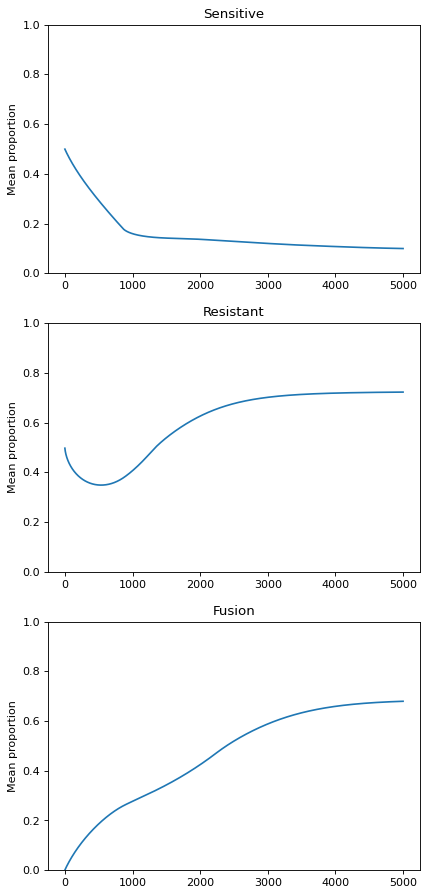

In [167]:
A_means = [mat.mean() for mat in A_hist]
B_means = [mat.mean() for mat in B_hist]
F_means = [mat.mean() for mat in F_hist]

plt.figure(num=None, figsize=(6, 14), dpi=80, facecolor='w', edgecolor='k')
plt.subplot2grid((3,2), (0,0), colspan=2)
plt.plot(A_means)
plt.title('Sensitive')
plt.ylabel('Mean proportion')
plt.ylim((0, 1))
plt.subplot2grid((3,2), (1,0), colspan=2)
plt.plot(B_means)
plt.title('Resistant')
plt.ylabel('Mean proportion')
plt.ylim((0, 1))
plt.subplot2grid((3,2), (2,0), colspan=2)
plt.plot(F_means)
plt.title('Fusion')
plt.ylabel('Mean proportion')
plt.ylim((0, 1))
